In [16]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,StandardScaler,PowerTransformer, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from scipy.stats import boxcox,yeojohnson, pearsonr
import seaborn as sns
import matplotlib.pyplot as plt

In [34]:
# Loading the dataset with a specific encoding
df = pd.read_csv('2 - RamsArena_DataSet.csv', encoding='ISO-8859-1')
# Use any condition from below to see the change 
#df = df[df['East = 1/ West = 0']==1]
#df = df[df['East = 1/ West = 0']==0]
#df = df[df['Community Inclusion']<=45]
#df = df[df['Community Inclusion']>45]
df = df[df['Early Education Enrollment Score']<=45]

# Dropping Percentage of Community Inclusion, Children Enrolled Under 5 and Percentage of Children Enrolled Age 3 and 4 columns 
# because they are highly correlated with the Early Education Enrollment Score
df = df.drop(['Community Inclusion','Percentage of Children Enrolled Under 5','Percentage of Children Enrolled Age 3 and 4','East = 1/ West = 0'],axis=1)

# Removing rows with N/A values in Early Education Enrollment Score column
df.dropna(subset=['Early Education Enrollment Score'], inplace=True)

## Removing commas from Median Income Column
df['Median Income'] = df['Median Income'].str.replace(',', '', regex=False)   

In [35]:
#Number of rows and columns left after filtering the master dataset 
print(df.shape)

(38, 47)


In [36]:
# Normalization using Standard Scaler 

# Dropping Columns containing Census Tract Information 
df_normalized = df.drop(['GEO_ID','Geographic Area Name','Census Tract FIPS code'],axis=1)
#Converting rest of the columns to numeric 
df_normalized = df_normalized.apply(pd.to_numeric,errors='coerce')
# Fitting and transforming the standardization scaler onto the data
stan = StandardScaler().fit(df_normalized)
df_normalized_stan = stan.transform(df_normalized)
# Assigning original feature names for ease of read
df_normalized_stan = pd.DataFrame(df_normalized_stan, columns = [f"{col}_scaled" for col in df_normalized.columns])

In [37]:
print(df_normalized_stan.shape)

(38, 44)


In [38]:
final_df = df_normalized_stan.copy()
# Resetting the index of final_df
final_df.reset_index(drop=True, inplace=True)
# Resetting index for GEO_ID to ensure alignment
geo_id_values = df['GEO_ID'].reset_index(drop=True) 
census_tract_values = df['Census Tract FIPS code'].reset_index(drop=True)
geo_name_values = df['Geographic Area Name'].reset_index(drop=True)
# Inserting the deleted columns into final_df at right position 
final_df.insert(0, 'GEO_ID', geo_id_values)
final_df.insert(1,'Census Tract FIPS code',census_tract_values)
final_df.insert(2,'Geographic Area Name',geo_name_values)

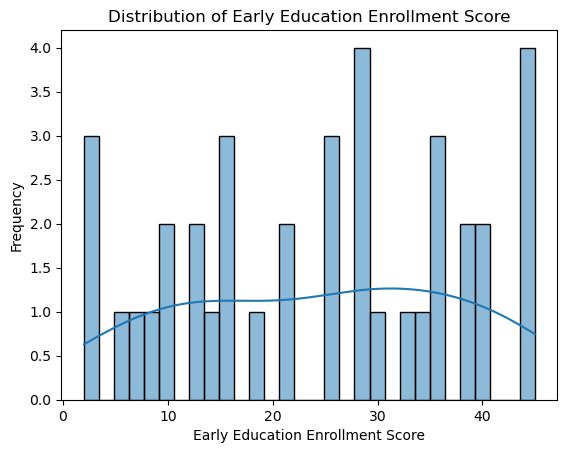

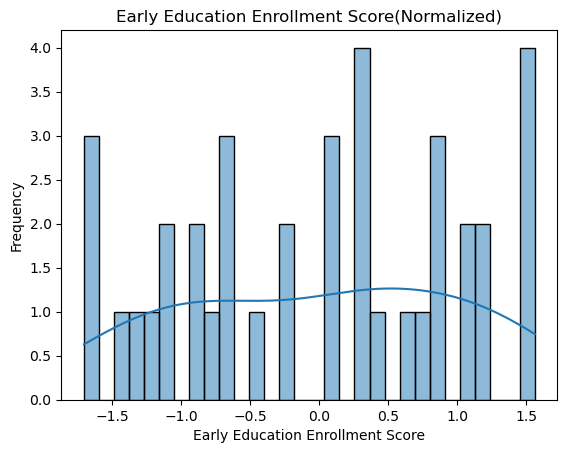

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plotting the histogram before and after normalization to see if there is any change in distribution after normalization 
sns.histplot(df['Early Education Enrollment Score'], bins=30, kde=True)
plt.title('Distribution of Early Education Enrollment Score')
plt.xlabel('Early Education Enrollment Score')
plt.ylabel('Frequency')
plt.show()

sns.histplot(final_df['Early Education Enrollment Score_scaled'], bins=30, kde=True)
plt.title('Early Education Enrollment Score(Normalized)')
plt.xlabel('Early Education Enrollment Score')
plt.ylabel('Frequency')
plt.show()

In [40]:
# Calculating skew for all numeric columns
skew_values = final_df.skew(numeric_only=True)
moderate_to_high_skew = skew_values[skew_values>=0.5]
# Displaying the skew values
print(moderate_to_high_skew)

Families with income below 50 percent of poverty level_scaled            1.794323
Percent of families below poverty level_scaled                           2.041842
Married-couple families with related children under 5 years_scaled       1.511381
Single female householder with  related children under 5 years_scaled    1.519683
Means of transportation-Public transportation_scaled                     3.326615
Means of transportation-Walked_scaled                                    4.143286
Means of transportation-Bicycle_scaled                                   6.164414
Worked from home_scaled                                                  0.704770
Mean travel time to work (minutes)_scaled                                0.665615
No vehicle available_scaled                                              2.750873
1 vehicle available_scaled                                               1.361067
Occupation-Management _scaled                                            1.244732
Occupation-Busin

In [41]:
# Selecting only numeric columns to transform skewness
numeric_cols = final_df.select_dtypes(include=[np.number])
# Census Tract FIPS code is a numeric column but we don't want to transform it as it contains census tract infromation
numeric_cols = numeric_cols.drop('Census Tract FIPS code',axis=1)
# Initializing PowerTransformer (Yeo-Johnson)
pt = PowerTransformer(method='yeo-johnson')
# Transforming the numeric columns
df_transformed = pd.DataFrame(pt.fit_transform(numeric_cols), columns=numeric_cols.columns)
# Checking for NaNs and Infs in the DataFrame
df_transformed = df_transformed.replace([np.inf, -np.inf], np.nan).dropna()
# Checking the skewness after transformation
print(df_transformed.skew())

Early Education Enrollment Score_scaled                                 -0.008116
Median Income_scaled                                                     0.028129
Families with income below 50 percent of poverty level_scaled            0.260706
Percent of families below poverty level_scaled                           0.332502
Married-couple families with related children under 5 years_scaled       0.107315
Single female householder with  related children under 5 years_scaled    0.339058
Total Number of Families with no earner_scaled                           0.035778
Total Number of Families with 1 earner_scaled                            0.054854
Total Number of Families with 2 earners_scaled                           0.033187
Bachelors Percent_scaled                                                 0.016850
Commute Mins_scaled                                                      0.017577
Means of transportation-Car, truck, or van_scaled                       -0.090070
Means of transpo

C:\Users\DELL\AppData\Local\Temp\ipykernel_7004\3352127178.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Feature': col, 'Correlation': corr, 'P-Value':round(p_value, 4)}, ignore_index=True)
C:\Users\DELL\AppData\Local\Temp\ipykernel_7004\3352127178.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Feature': col, 'Correlation': corr, 'P-Value':round(p_value, 4)}, ignore_index=True)
C:\Users\DELL\AppData\Local\Temp\ipykernel_7004\3352127178.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Feature': col, 'Correlation': corr, 'P-Value':round(p_value, 4)}, ignore_index=True)
C:\Users\DELL\AppData\Local\Temp\ipykernel_7004\3352127178.py

                                              Feature  Correlation  P-Value
12              Means of transportation-Walked_scaled     0.510600   0.0011
2      Percent of families below poverty level_scaled     0.396160   0.0138
33  Occupation-Building and grounds cleaning and m...     0.375207   0.0203
3   Married-couple families with related children ...    -0.366334   0.0237
19                        2 vehicles available_scaled    -0.359268   0.0267
8                            Bachelors Percent_scaled    -0.349731   0.0314
28  Occupation- Arts, design, entertainment, sport...    -0.347811   0.0324
21  Occupation-Business and financial operations_s...    -0.322868   0.0480
36  Occupation-Office and administrative support _...    -0.316381   0.0530
11  Means of transportation-Public transportation_...     0.305676   0.0620
0                                Median Income_scaled    -0.305587   0.0621
23     Occupation-Architecture and engineering_scaled    -0.283682   0.0844
1   Families

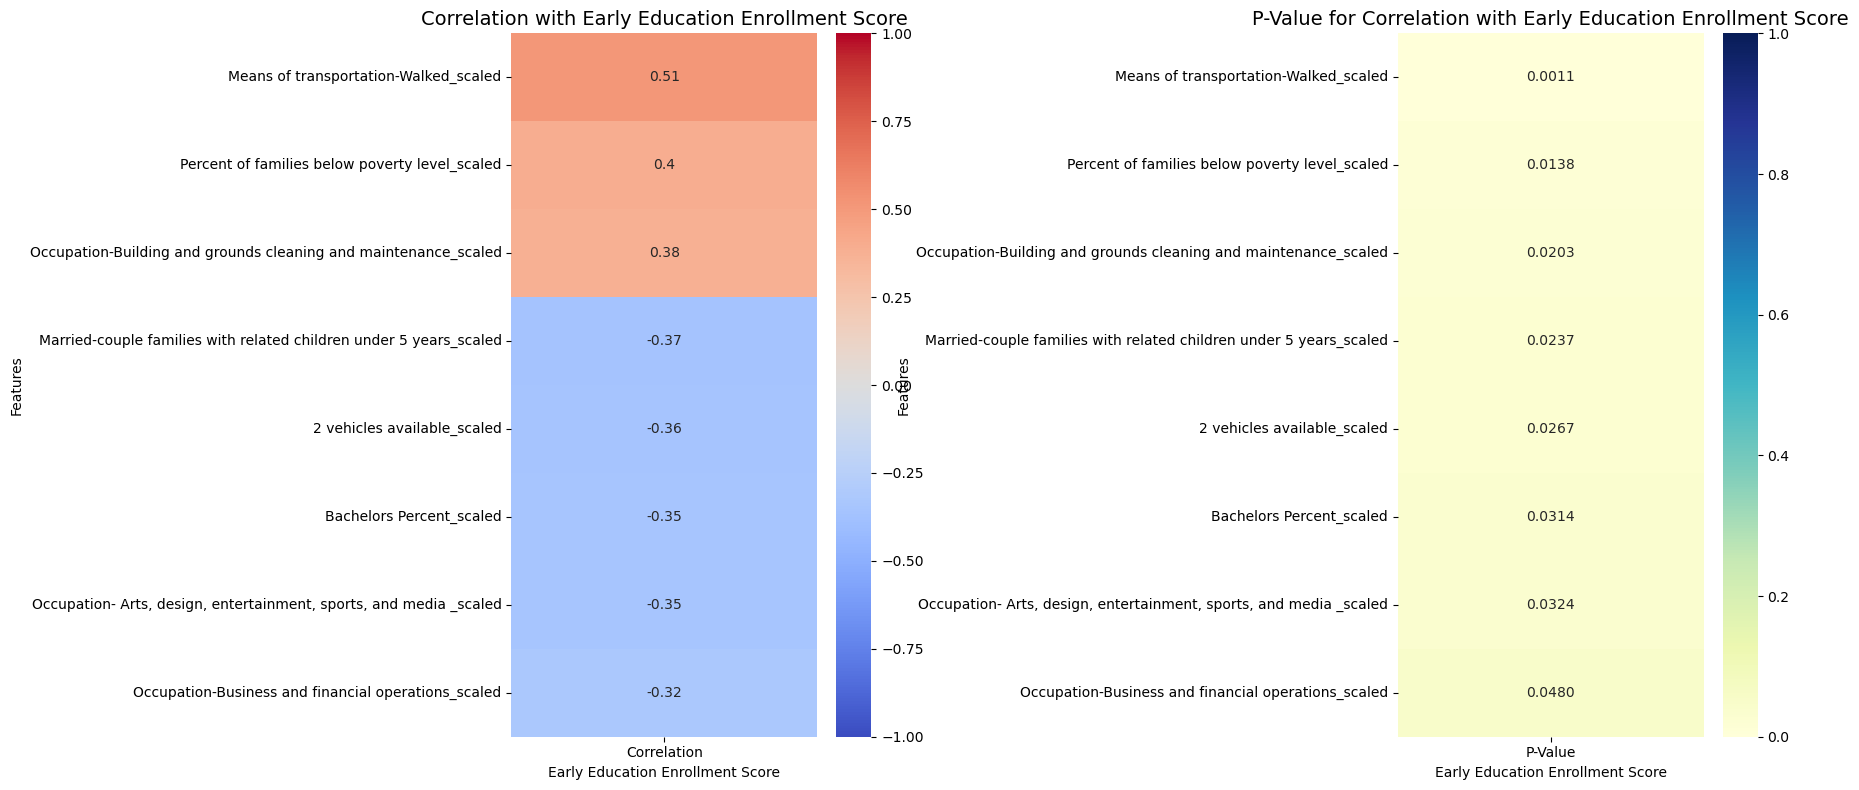

In [42]:
# Finding Correlation between denedent variable to all other independent variables. 
# We selected 'Early Education Enrollment Score' as our dependant variable
corr_df = df_transformed.copy()
corr_df = corr_df.dropna()

# Creating empty lists to store correlation and p-values
corr_values = []
p_values = []

# Creating empty DataFrames to store correlation coefficients and p-values
results = pd.DataFrame(columns=['Feature', 'Correlation', 'P-Value'])

# Loop through each pair of features
for col in corr_df.columns:
    if col != 'Early Education Enrollment Score_scaled':
        corr, p_value = pearsonr(corr_df[col], corr_df['Early Education Enrollment Score_scaled'])
        corr_values.append([col, corr])
        p_values.append([col, p_value])
        results = results.append({'Feature': col, 'Correlation': corr, 'P-Value':round(p_value, 4)}, ignore_index=True)
        
# Displaying the correlation matrix and p-value matrix
print(results.sort_values(by='P-Value', ascending=True))
# Filtering out only the significant columns with p-value<0.05
significant_p_values = results[results['P-Value']<=0.05]

# Visualizing Correlation with P-value

# Sorting by p-value in ascending order to visualize significant correlations
pval_df = pd.DataFrame(significant_p_values, columns=['Feature', 'P-Value']).set_index('Feature').sort_values(by='P-Value')
corr_df_copy = pd.DataFrame(significant_p_values, columns=['Feature', 'Correlation']).set_index('Feature').reindex(pval_df.index)

# Identifying n number of features with the highest p-values (Most insignificant features)
insignificant_features = pval_df.sort_values(by='P-Value', ascending=False).head(30).index
# Dropping these features from the dataset
# df_new will be used for Linear Regression in the next step
df_new = df_transformed.drop(columns=insignificant_features)

# Plot settings
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Correlation Heatmap
sns.heatmap(corr_df_copy, annot=True, cmap='coolwarm', vmin=-1, vmax=1, ax=axes[0], cbar=True)
axes[0].set_title('Correlation with Early Education Enrollment Score', fontsize=14)
axes[0].set_xlabel('Early Education Enrollment Score')
axes[0].set_ylabel('Features')

# P-Value Heatmap
sns.heatmap(pval_df, annot=True, cmap='YlGnBu',fmt='.4f', vmin=0, vmax=1, ax=axes[1], cbar=True)
axes[1].set_title('P-Value for Correlation with Early Education Enrollment Score', fontsize=14)
axes[1].set_xlabel('Early Education Enrollment Score')
axes[1].set_ylabel('Features')

# Adjust layout
plt.tight_layout()

# Saving the plots
fig.savefig('correlation_pvalue_heatmaps_for_Early_Education_Enrollment_Score.png', bbox_inches='tight')

# Displaying the plot
plt.show()

In [43]:
# Number of columns left after dropping the columns 
print(df_new.shape)

(38, 36)


In [44]:
# Using Linear Regression for exploring how changes in independent variables affect the dependent variable 
# Defining X (features) and Y (target) from the dataset
X = df_new.copy()
X = X.dropna()
X = X.drop(['Early Education Enrollment Score_scaled'],axis=1)
Y = df_transformed['Early Education Enrollment Score_scaled']

# Adding a constant to the model (for the intercept)
X = sm.add_constant(X)

# Fitting the OLS model
model = sm.OLS(Y, X).fit()

# Extracting coefficients and p-values
results_df = pd.DataFrame({
    'Feature': model.params.index,
    'Coefficient': model.params.values.round(4),
    'P-Value': model.pvalues.values.round(4)
})

# Sorting by P-Value
results_df = results_df.sort_values(by='P-Value')
print(results_df)


                                              Feature  Coefficient  P-Value
35                  Occupation-Material moving_scaled      -1.4384   0.0132
33                       Occupation-Production_scaled       1.9879   0.0144
2   Families with income below 50 percent of pover...      -1.8167   0.0172
3   Single female householder with  related childr...       1.2346   0.0177
16                      Occupation-Management _scaled      -3.4179   0.0198
19  Occupation-Life, physical, and social science_...       1.3759   0.0207
26  Occupation-Food preparation and serving relate...       1.6027   0.0215
15                         1 vehicle available_scaled      -0.8590   0.0277
8   Means of transportation-Car, truck, or van_scaled      -2.6645   0.0293
9   Means of transportation-Public transportation_...       1.1382   0.0300
10             Means of transportation-Bicycle_scaled       1.1103   0.0304
14                        No vehicle available_scaled      -0.6764   0.0385
21          

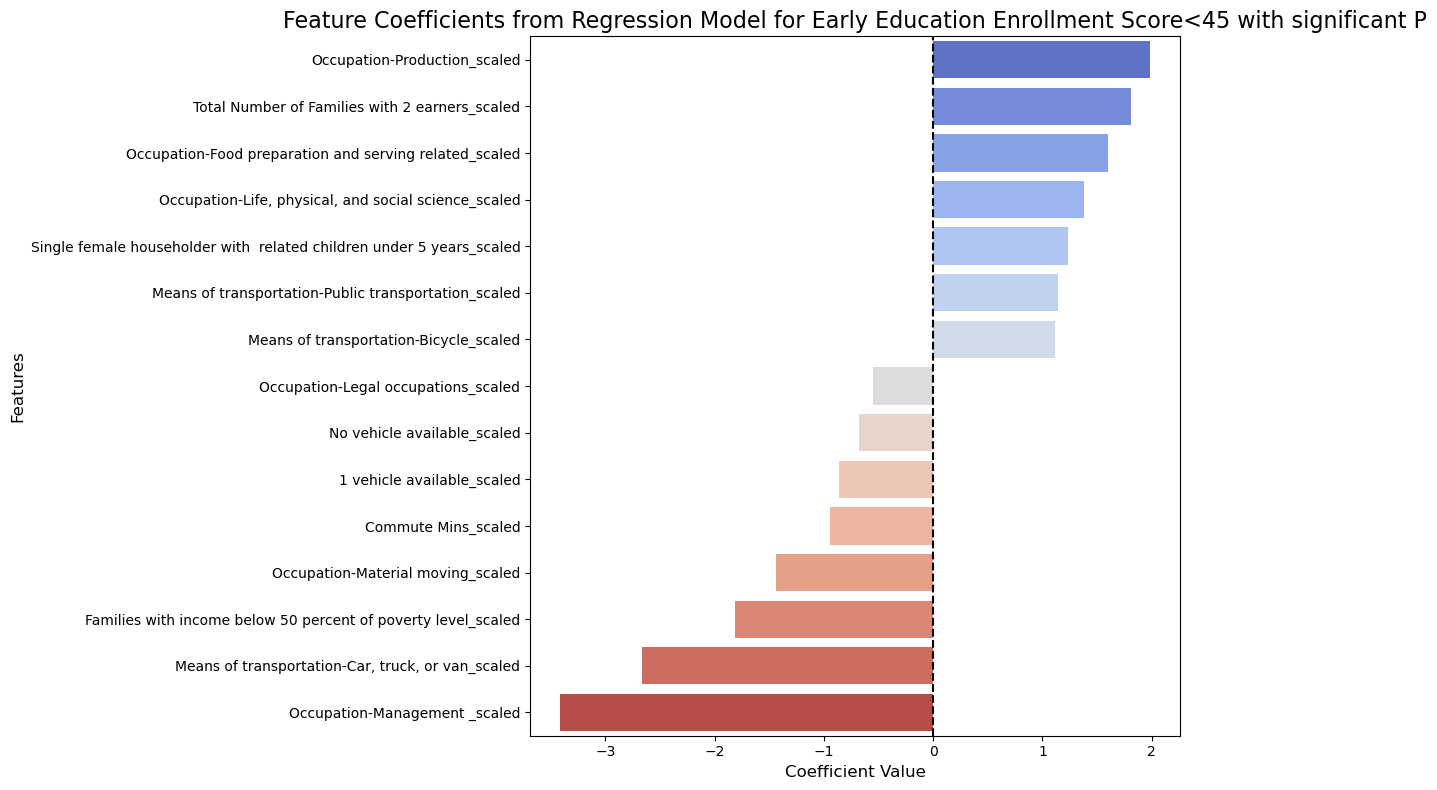

In [33]:
# Visualizing the Feature Coefficients from Regression Model

# Filtering features with P-value < 0.05 (or any threshold you need)
significant_features = results_df[results_df['P-Value']<0.05]

# Sorting by coefficient value for better visualization
significant_features = significant_features.sort_values(by='Coefficient', ascending=False)

# Creating the plot
plt.figure(figsize=(12, 8))
sns.barplot(
    x=significant_features['Coefficient'], 
    y=significant_features['Feature'], 
    palette='coolwarm',  
    orient='h' 
)

# Adding labels and title
plt.title('Feature Coefficients from Regression Model for Early Education Enrollment Score<45 with significant P', fontsize=16)
plt.xlabel('Coefficient Value', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.axvline(0, color='black', linestyle='--')
plt.tight_layout()

# Saving the plot
plt.savefig("Feature_Coefficients_from_Regression_Model_for_Early Education Enrollment Score_for_significant_P.png", bbox_inches='tight')

# Displaying the plot
plt.show()